Analyse the Pokemon data using some Pandas features in addition to charting with Seaborn

In [1]:
import pandas as pd
import numpy as np

# Patch statsmodels kdetools
def _revrt(X,m=None):
    """
    Inverse of forrt. Equivalent to Munro (1976) REVRT routine.
    """
    if m is None:
        m = len(X)
    i = int(m // 2+1)
    y = X[:i] + np.r_[0,X[i:],0]*1j
    return np.fft.irfft(y)*m

from statsmodels.nonparametric import kdetools

# replace the implementation with new method.
kdetools.revrt = _revrt
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.__version__

'0.22.0'

In [3]:
% matplotlib inline

In [4]:
df = pd.read_csv("Pokemon1.csv")
df.columns = ['id','name','type_1','type_2','total',
              'hp','attack','defense','sp_atk',
              'sp_def','speed','generation','legendary']
df.head()

id                   name type_1  type_2  total  hp  attack  defense  \
0   1              Bulbasaur  Grass  Poison    318  45      49       49   
1   2                Ivysaur  Grass  Poison    405  60      62       63   
2   3               Venusaur  Grass  Poison    525  80      82       83   
3   3  VenusaurMega Venusaur  Grass  Poison    625  80     100      123   
4   4             Charmander   Fire     NaN    309  39      52       43   

   sp_atk  sp_def  speed  generation  legendary  
0      65      65     45           1      False  
1      80      80     60           1      False  
2     100     100     80           1      False  
3     122     120     80           1      False  
4      60      50     65           1      False

In [5]:
# Statistics for each attribute
df[['total','hp','attack','defense','sp_atk','sp_def','speed']].describe().round(1)

total     hp  attack  defense  sp_atk  sp_def  speed
count  800.0  800.0   800.0    800.0   800.0   800.0  800.0
mean   435.1   69.3    79.0     73.8    72.8    71.9   68.3
std    120.0   25.5    32.5     31.2    32.7    27.8   29.1
min    180.0    1.0     5.0      5.0    10.0    20.0    5.0
25%    330.0   50.0    55.0     50.0    49.8    50.0   45.0
50%    450.0   65.0    75.0     70.0    65.0    70.0   65.0
75%    515.0   80.0   100.0     90.0    95.0    90.0   90.0
max    780.0  255.0   190.0    230.0   194.0   230.0  180.0

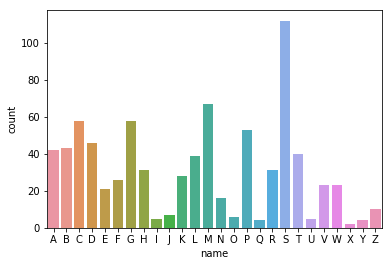

In [6]:
# How common are Pokemon names starting with each letter
sns.countplot(x=df['name'].str[0], order=sorted(df['name'].str[0].unique()))

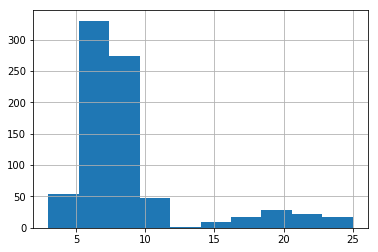

In [7]:
# How long are the names
name_lengths = df['name'].map(lambda name: len(name))
name_lengths.hist()

In [8]:
# Top 10 Pokemon by total attribute
top_10_total = df.sort_values(ascending=False, by='total').head(10)

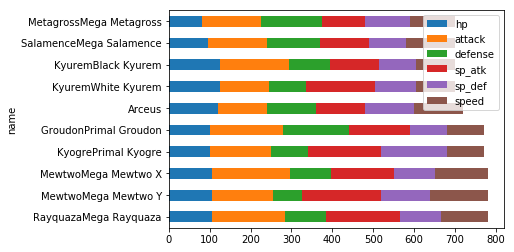

In [9]:
(
    top_10_total[['name','hp','attack','defense','sp_atk','sp_def','speed']]
    .set_index('name')
    .plot(kind='barh', stacked=True)
)

In [10]:
# Average total attribute by generation
df.groupby('generation')['total'].mean()

generation
1    426.813253
2    418.283019
3    436.225000
4    459.016529
5    434.987879
6    436.378049
Name: total, dtype: float64

In [11]:
# How many types are there
all_types = list(set(df.type_1.unique()) & set(df.type_2.unique()))
print('Pokemon can have any of the following {} types:'.format(len(all_types)))
print(all_types)

Pokemon can have any of the following 18 types:
['Fighting', 'Fairy', 'Bug', 'Psychic', 'Ghost', 'Grass', 'Dragon', 'Water', 'Normal', 'Poison', 'Flying', 'Electric', 'Ground', 'Fire', 'Ice', 'Steel', 'Dark', 'Rock']


In [12]:
print('Type 1 contains {} unique elements'.format(df['type_1'].nunique()))
print('Type 2 contains {} unique elements'.format(df['type_2'].dropna().nunique()))

Type 1 contains 18 unique elements
Type 2 contains 18 unique elements


In [13]:
type_1_set = set(df['type_1'])
type_2_set = set(df['type_2'].dropna())
# ^ Return a new set with elements in either the set or other but not both.
# Looks like there are no unique types to either column
type_1_set ^ type_2_set

set()

In [14]:
# Variety of Pokemon by type in either type_1 or type_2
types = pd.get_dummies(df['type_1']) + pd.get_dummies(df['type_2'])
df_types = df.merge(types, left_index=True, right_index=True)
df_types[all_types].sum().sort_values(ascending=False)

Water       126
Normal      102
Flying      101
Grass        95
Psychic      90
Bug          72
Ground       67
Fire         64
Poison       62
Rock         58
Fighting     53
Dark         51
Dragon       50
Electric     50
Steel        49
Ghost        46
Fairy        40
Ice          38
dtype: int64

In [15]:
# Variety by generation
type_count_by_gen = df_types.groupby('generation')[all_types].sum()
type_count_by_gen.style.background_gradient(cmap='cool', axis=1)

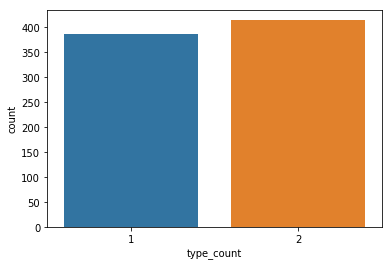

In [16]:
# How many Pokemon have either 1 or 2 types
df['type_count'] = 2
df.loc[df['type_2'].isnull(), 'type_count'] = 1
sns.countplot(df['type_count'])

In [17]:
df.groupby(['type_count'])['id'].count()

type_count
1    386
2    414
Name: id, dtype: int64

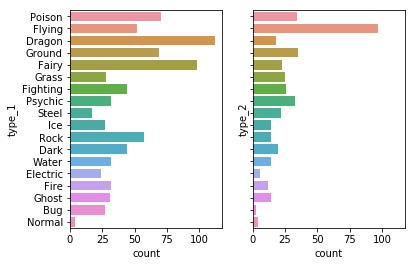

In [18]:
# How common is each type according to type_1 and type_2 columns
type_fig, (type_ax1, type_ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
sns.countplot(y=df['type_1'], ax=type_ax1)
sns.countplot(y=df['type_2'], ax=type_ax2)

In [19]:
# How common are the combinations
def reduce_type_combinations(pokemon):
    """Remove the permutations of types by sorting type_1 and type_2 for each Pokemon
       before returning a single string value representing the combination.
       For example:
       Pokemon X type_1 = Flying type_2 = Fire
       Pokemon Y type_1 = Fire   type_2 = Flying 
       They will both become 'Fire & Flying'"""
    t1 = pokemon['type_1']
    if pd.isnull(pokemon['type_2']):
        return t1
    t2 = pokemon['type_2']
    sorted_types = sorted([t1, t2])
    return ' & '.join(sorted_types)

df['type_combination'] = df.apply(reduce_type_combinations, axis=1)
more_than_1_type = df[df['type_2'].notnull()]

print('There are {} unique type combinations, including 1 and 2 type Pokemon.'.format(df['type_combination'].nunique()))
print('There are {} unique Pokemon 2 type combinations.'.format(more_than_1_type['type_combination'].nunique()))

There are 133 unique type combinations, including 1 and 2 type Pokemon.
There are 115 unique Pokemon 2 type combinations.


In [20]:
df.groupby('type_count')['total'].describe().round(2)

count    mean     std    min     25%    50%    75%    max
type_count                                                           
1           386.0  412.02  114.75  180.0  313.25  410.0  495.0  780.0
2           414.0  456.63  120.85  190.0  355.00  475.0  529.5  780.0

type_count
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: total, dtype: object

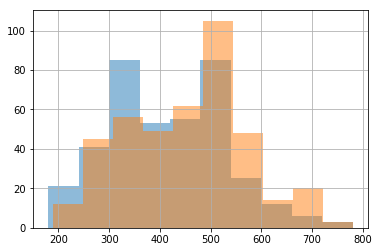

In [21]:
df.groupby('type_count')['total'].hist(alpha=0.5)

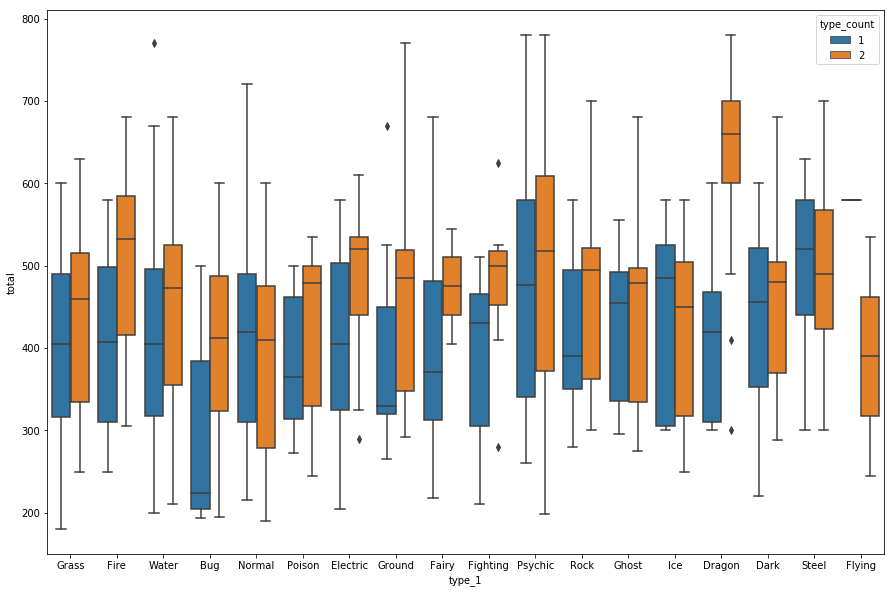

In [22]:
plt.figure(figsize=(15,10))
sns.boxplot(x='type_1', y='total', hue='type_count', data=df)

In [23]:
# The max hp for a single type pokemon is considerably higher than a combo type
df.groupby('type_count')['hp'].describe().round(2)

count   mean    std   min   25%   50%   75%    max
type_count                                                    
1           386.0  67.77  28.04  10.0  50.0  65.0  79.0  255.0
2           414.0  70.65  22.90   1.0  55.0  70.0  85.0  150.0

In [24]:
df[['name','type_combination','hp']].sort_values(ascending=False, by='hp').head(10)

name type_combination   hp
261                Blissey           Normal  255
121                Chansey           Normal  250
217              Wobbuffet          Psychic  190
351                Wailord            Water  170
655              Alomomola            Water  165
155                Snorlax           Normal  160
473               Drifblim   Flying & Ghost  150
313                Slaking           Normal  150
544  GiratinaAltered Forme   Dragon & Ghost  150
545   GiratinaOrigin Forme   Dragon & Ghost  150

type_count
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: hp, dtype: object

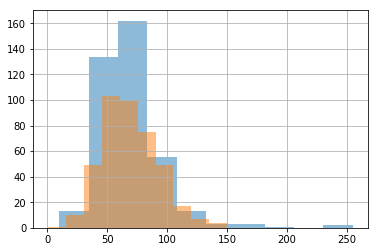

In [25]:
df.groupby('type_count')['hp'].hist(alpha=0.5)

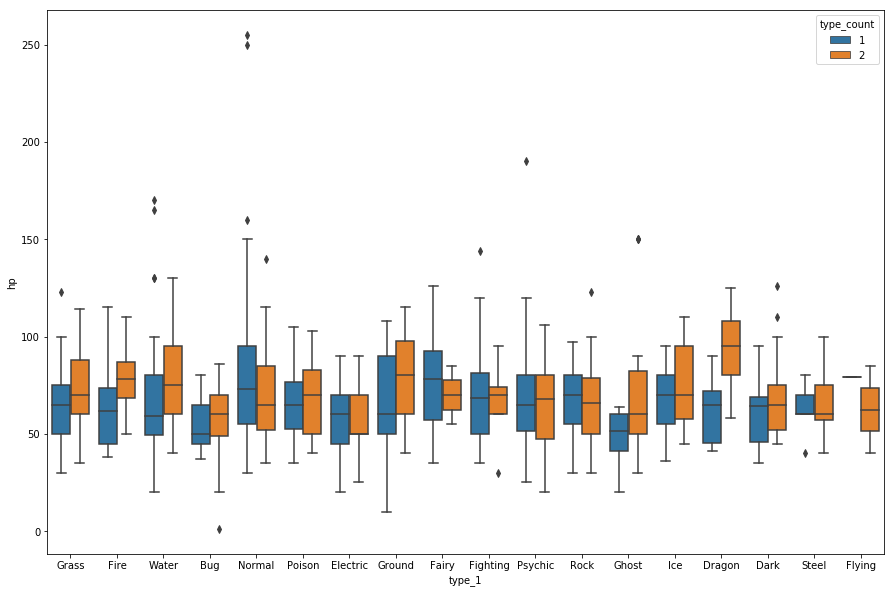

In [26]:
plt.figure(figsize=(15,10))
sns.boxplot(x='type_1', y='hp', hue='type_count', data=df)

In [27]:
df.groupby('type_count')['attack'].describe().round(2)

count   mean    std   min    25%   50%    75%    max
type_count                                                      
1           386.0  74.53  30.49   5.0  52.00  70.5   95.0  180.0
2           414.0  83.17  33.70  10.0  59.25  80.0  103.0  190.0

type_count
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: attack, dtype: object

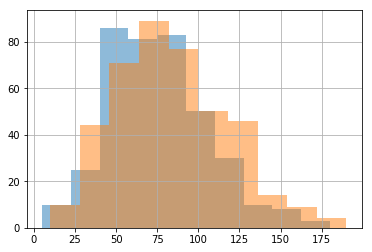

In [28]:
df.groupby('type_count')['attack'].hist(alpha=0.5)

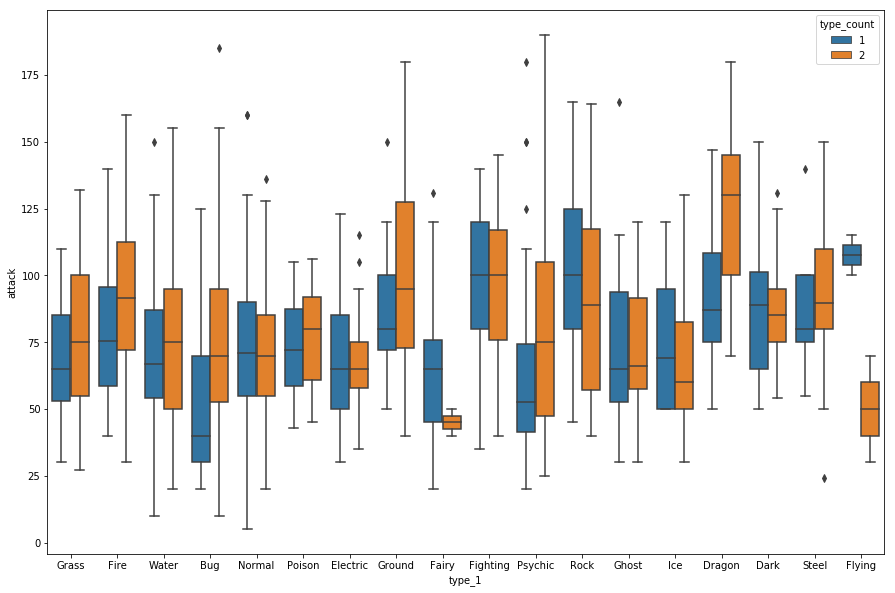

In [29]:
plt.figure(figsize=(15,10))
sns.boxplot(x='type_1', y='attack', hue='type_count', data=df)

In [30]:
df.groupby('type_count')['defense'].describe().round(2)

count   mean    std   min   25%   50%    75%    max
type_count                                                     
1           386.0  67.59  28.33   5.0  48.0  63.0   80.0  230.0
2           414.0  79.68  32.59  15.0  55.0  75.5  100.0  230.0

type_count
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: defense, dtype: object

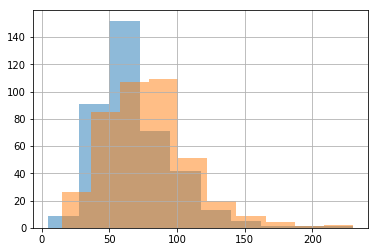

In [31]:
df.groupby('type_count')['defense'].hist(alpha=0.5)

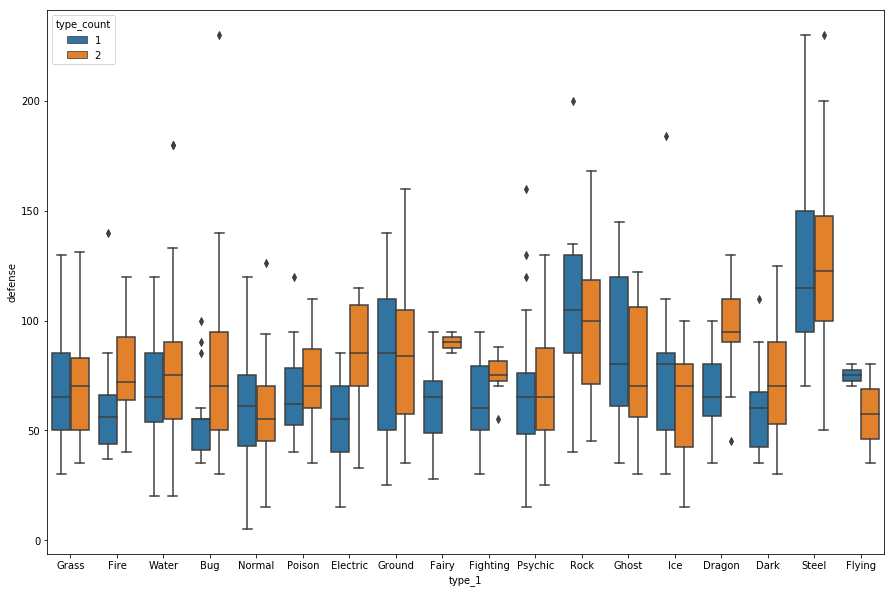

In [32]:
plt.figure(figsize=(15,10))
sns.boxplot(x='type_1', y='defense', hue='type_count', data=df)

In [33]:
df.groupby('type_count')['speed'].describe().round(2)

count   mean    std  min   25%   50%   75%    max
type_count                                                   
1           386.0  65.88  29.48  5.0  45.0  62.0  86.5  180.0
2           414.0  70.51  28.52  5.0  50.0  70.0  91.0  160.0

type_count
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: speed, dtype: object

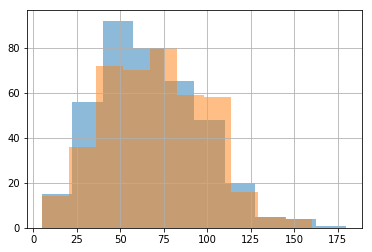

In [34]:
df.groupby('type_count')['speed'].hist(alpha=0.5)

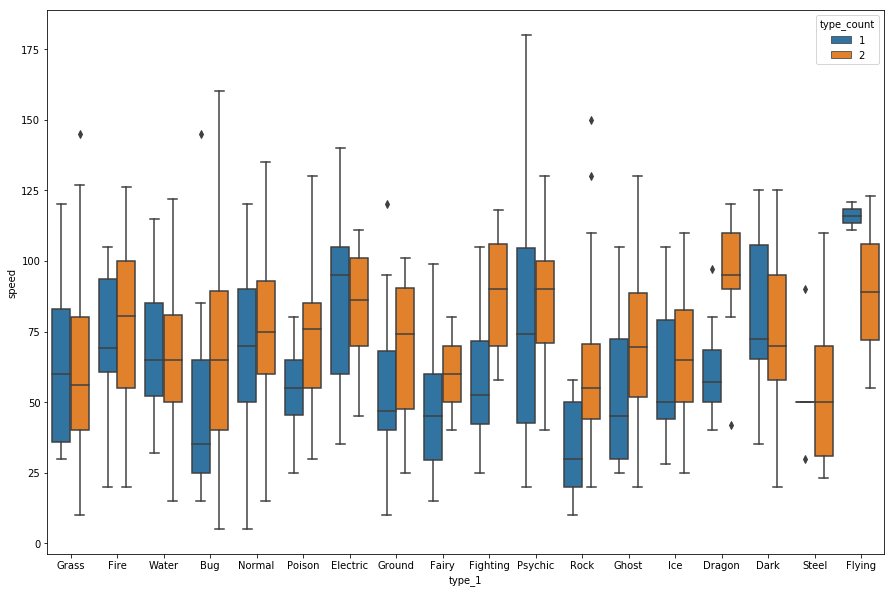

In [35]:
plt.figure(figsize=(15,10))
sns.boxplot(x='type_1', y='speed', hue='type_count', data=df)

c:\users\aman\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


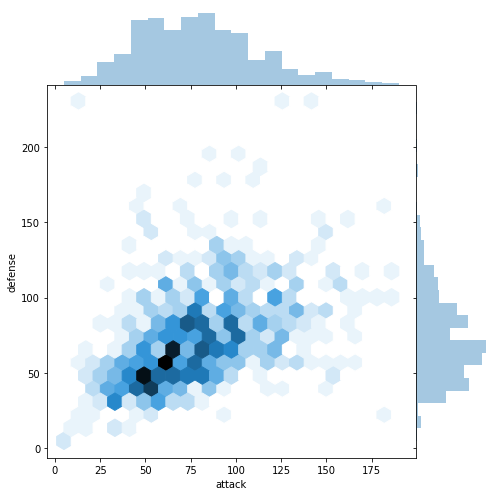

In [36]:
sns.jointplot(df['attack'], df['defense'], kind="hex", size=7, space=0)

In [41]:
# Total statistics for each type, which ARE part of a combination of types
def stacked_combo_type_attributes(df, attribute):
    if isinstance(attribute, list):
        columns = ['type_combination'] + attribute
        columns1 = ['1'] + attribute
        columns2 = ['2'] + attribute
    else:
        columns = ['type_combination', attribute]
        columns1 = ['1', attribute]
        columns2 = ['2', attribute]
    type_combination_totals = more_than_1_type[columns]
    type_combination_totals['1'], type_combination_totals['2'] = type_combination_totals['type_combination'].str.split(' & ').str

    stacked_type_attributes = (
        type_combination_totals[columns1]
        .rename(columns={'1':'type'})
        .append(
           type_combination_totals[columns2]
           .rename(columns={'2': 'type'})
           )
    )
    
    return stacked_type_attributes

def describe_attribute_combo_type_pokemon(df, attribute):
    stacked_type_attributes = stacked_combo_type_attributes(df, attribute)
    combo_type_stats = (
        stacked_type_attributes
        .groupby('type')[attribute]
        .describe()
        .round(1)
        .reset_index()
        .pivot_table(index='type', columns='level_1', values=attribute)
    )
    
    return combo_type_stats


In [42]:
stacked_types = stacked_combo_type_attributes(df, ['hp','speed','attack','defense'])

c:\users\aman\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [43]:
grass = stacked_types[stacked_types['type'] == 'Grass']
water = stacked_types[stacked_types['type'] == 'Water']
fire = stacked_types[stacked_types['type'] == 'Fire']
electric = stacked_types[stacked_types['type'] == 'Electric']

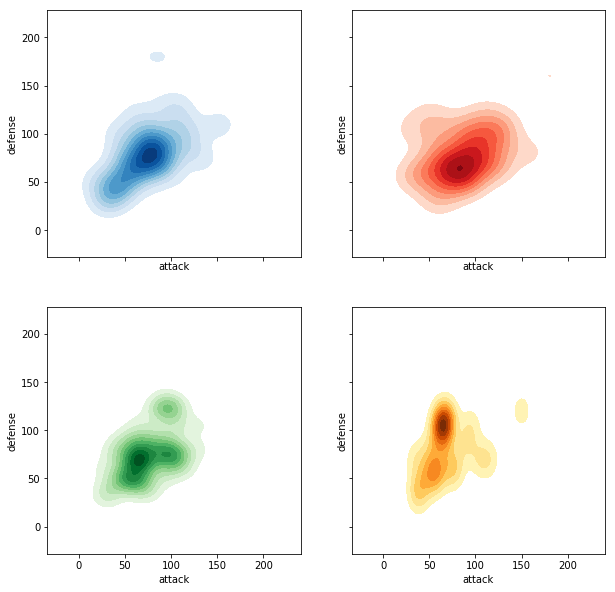

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

sns.kdeplot(water.attack, water.defense, ax=axes[0, 0],
            cmap="Blues", shade=True, shade_lowest=False)
sns.kdeplot(fire.attack, fire.defense, ax=axes[0, 1],
            cmap="Reds", shade=True, shade_lowest=False)
sns.kdeplot(grass.attack, grass.defense, ax=axes[1, 0],
            cmap="Greens", shade=True, shade_lowest=False)
sns.kdeplot(electric.attack, electric.defense, ax=axes[1, 1],
            cmap="YlOrBr", shade=True, shade_lowest=False)

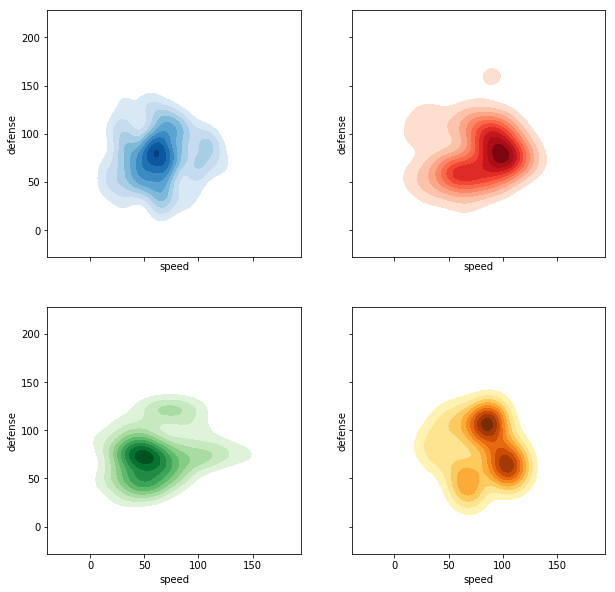

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

sns.kdeplot(water.speed, water.defense, ax=axes[0, 0],
            cmap="Blues", shade=True, shade_lowest=False)
sns.kdeplot(fire.speed, fire.defense, ax=axes[0, 1],
            cmap="Reds", shade=True, shade_lowest=False)
sns.kdeplot(grass.speed, grass.defense, ax=axes[1, 0],
            cmap="Greens", shade=True, shade_lowest=False)
sns.kdeplot(electric.speed, electric.defense, ax=axes[1, 1],
            cmap="YlOrBr", shade=True, shade_lowest=False)

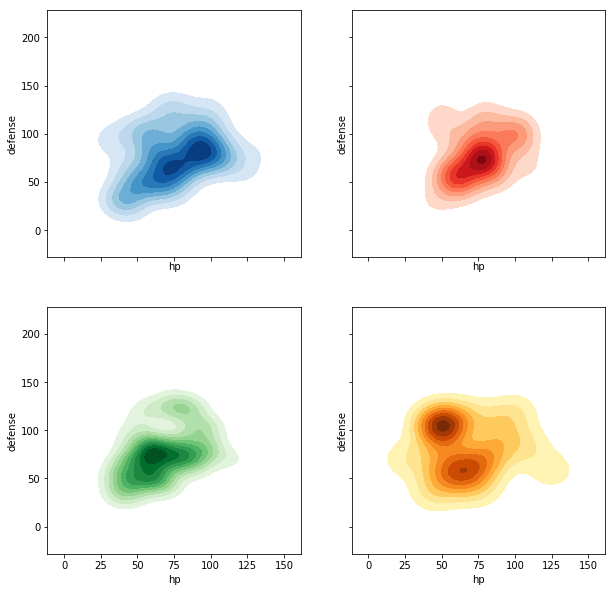

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

sns.kdeplot(water.hp, water.defense, ax=axes[0, 0],
            cmap="Blues", shade=True, shade_lowest=False)
sns.kdeplot(fire.hp, fire.defense, ax=axes[0, 1],
            cmap="Reds", shade=True, shade_lowest=False)
sns.kdeplot(grass.hp, grass.defense, ax=axes[1, 0],
            cmap="Greens", shade=True, shade_lowest=False)
sns.kdeplot(electric.hp, electric.defense, ax=axes[1, 1],
            cmap="YlOrBr", shade=True, shade_lowest=False)

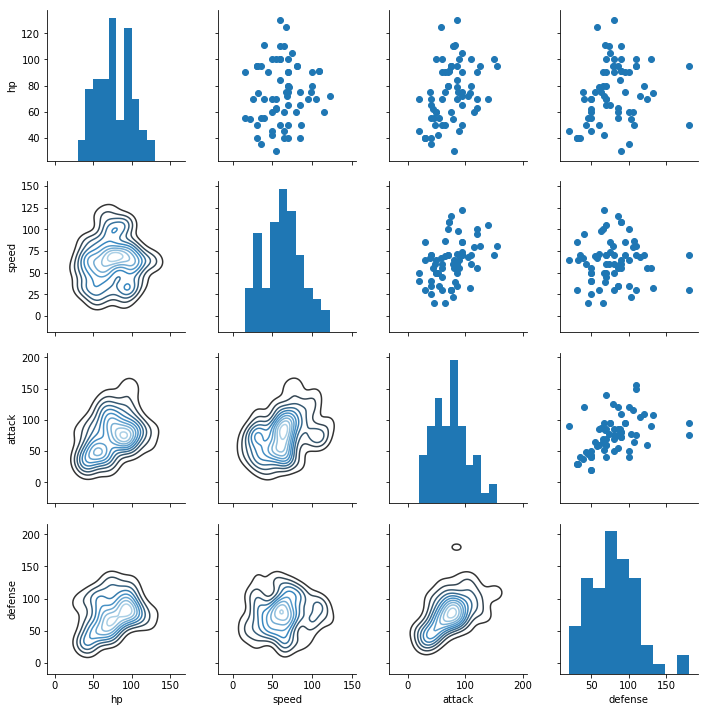

In [47]:
g = sns.PairGrid(water, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(plt.hist)

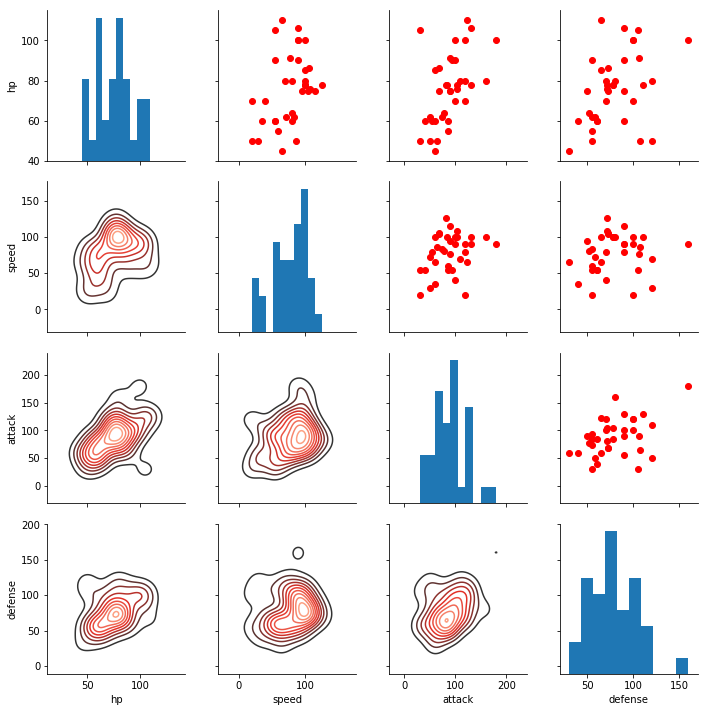

In [48]:
g = sns.PairGrid(fire, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Reds_d")
g.map_upper(plt.scatter, color='Red')
g.map_diag(plt.hist)

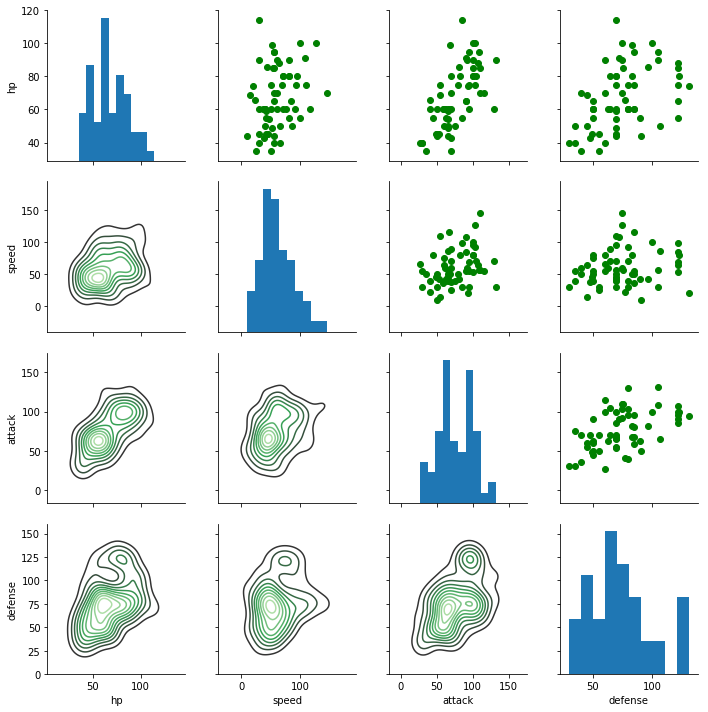

In [49]:
g = sns.PairGrid(grass, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Greens_d")
g.map_upper(plt.scatter, color='Green')
g.map_diag(plt.hist)

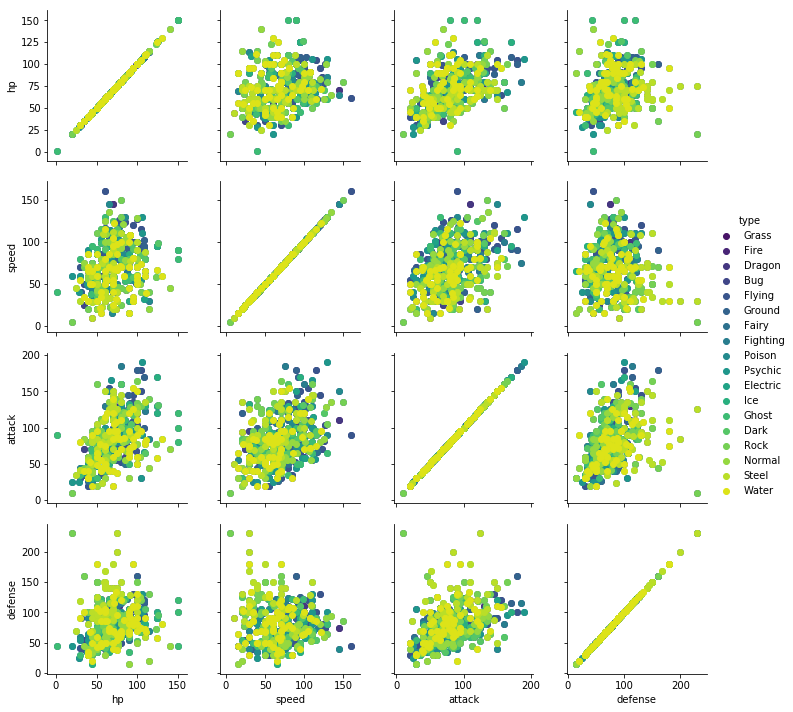

In [50]:
g = sns.PairGrid(stacked_types, hue="type", palette="viridis")
g.map(plt.scatter)
g.add_legend()